In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree
import sys
import pickle
import warnings
import shutil
import os
import re

%matplotlib inline
warnings.filterwarnings('ignore')

In [8]:
# issue : https://stackoverflow.com/questions/42562876/opencv3-error-unable-to-stop-the-stream-inappropriate-ioctl-for-device

def convert_video_to_frames(video_file_name, video_file_path, frame_output_path):
    vidcap = cv2.VideoCapture(video_file_path)
    count = 1
    success = True
    while success:
        success,image = vidcap.read()
        if success:
            cv2.imwrite('{0}/{1}_frame_{2}.jpg'.format(frame_output_path,video_file_name,count), image)
        count += 1
    vidcap.release()
        
def plot_boundaries(img_path, x, y, width, height):
    img = cv2.imread(img_path)
    cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16,19))
    plt.imshow(gray)
    plt.show()

In [9]:
#convert_video_to_frames('Attack_CloseUp_Day_Empty_1_2_1','data/Attack_CloseUp_Day_Empty_1_2_1.mp4','data/Attack_CloseUp_Day_Empty_1_2_1')

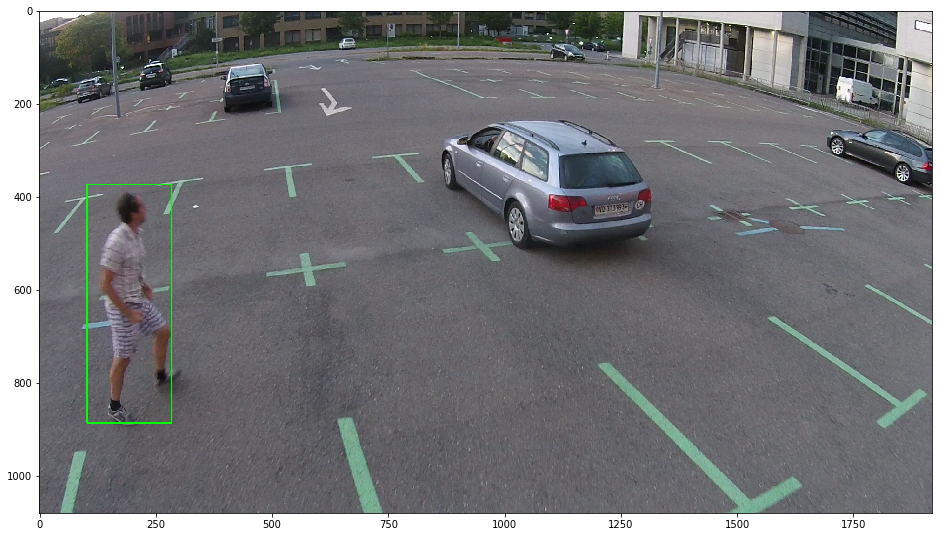

In [12]:
plot_boundaries('/home/vijin/iith/project/data/mini-drone-data_processed/test/Attack_CloseUp_Day_Empty_1_2_1/Attack_CloseUp_Day_Empty_1_2_1_frame_409.jpg', 103, 374, 181, 512)

In [ ]:
# TO DO : run for files with no person, one person and morethan one person

def get_frames_from_span(frame_dict, label):
    frames = {}
    if frame_dict:
        x = int(frame_dict['x'])
        y = int(frame_dict['y'])
        width = int(frame_dict['width'])
        height = int(frame_dict['height'])
        frame_span = frame_dict['framespan']
        
        for i in range(int(frame_span.split(':')[0]) , int(frame_span.split(':')[1])+1):
            if i not in frames:
                frames[i] = list()
            frames[i].append((x-1, y-1, x + width-1,y + height-1,label))
    return frames

def parse_xgtf_ann_file(file_name, object_type): 
    master_frame_map = {}
    root = xml.etree.ElementTree.parse(file_name).getroot()
    for child in root:
        if 'data' in child.tag:
            for obj in child.getchildren()[0].getchildren():
                if 'object' in obj.tag and obj.attrib['name'] == object_type:
                    object_id = obj.attrib['id']
                    for attr in obj.getchildren():
                        if 'attribute' in attr.tag and (attr.attrib['name'] == 'box' or attr.attrib['name'] == 'obox'):
                            for bbox in attr.getchildren():
                                if 'bbox' in bbox.tag:
                                    frame_map = get_frames_from_span(bbox.attrib, object_type)
                                    # Check whether multiple persons are present in same frame
                                    if not master_frame_map:
                                        master_frame_map = frame_map
                                    else:
                                        for frame in frame_map.keys():
                                            if frame_map[frame] is not None:
                                                if frame not in master_frame_map:
                                                    master_frame_map[frame] = list()
                                                master_frame_map[frame].extend(frame_map[frame])
    return master_frame_map

In [ ]:
def draw_boundaries(frame_data, video_file_name,root_folder, output_folder):
    if frame_data:
        for frame in frame_data.keys():
            img = cv2.imread('{0}/{1}_frame_{2}.jpg'.format(root_folder, video_file_name, frame))
            if not img is None:
                for ann in frame_data[frame]:
                    cv2.rectangle(img, (ann[0], ann[1]), (ann[2], ann[3]), (0, 255, 0), 2)
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)

                cv2.imwrite('{0}/{1}_frame_{2}.jpg'.format(output_folder, video_file_name, frame),gray)

In [ ]:
#frame_data = parse_xgtf_ann_file('data/Attack_CloseUp_Day_Empty_1_2_1.xgtf', 'Person')

In [ ]:
#draw_boundaries(frame_data, 'Attack_CloseUp_Day_Empty_1_2_1', 'data/Attack_CloseUp_Day_Empty_1_2_1', 'data/Attack_CloseUp_Day_Empty_1_2_1_ann')

In [ ]:
def process_videos(input_folder, output_folder, classification_folder, annotation_file_format = '.xgtf', object_type = 'Person'):
    for x in os.listdir(input_folder):
        if '.mp4' in x:
            video_file_path = '{0}/{1}'.format(input_folder, x)
            video_file_name = x.split('.')[0]
            print('Processing {0}....'.format(x))
            # creates folder for frames
            print('creating frames....')
            frame_out_folder = '{0}/{1}'.format(output_folder, video_file_name) 
            if not os.path.isdir(frame_out_folder):
                os.makedirs(frame_out_folder)

            # convert video to frames and write to output folder
            convert_video_to_frames(video_file_name, video_file_path, frame_out_folder)

            # read xml based annotation file and write as python dict object
            print('creating annotation object....')
            ann_file = '{0}/{1}{2}'.format(input_folder, video_file_name, annotation_file_format)
            frame_data = parse_xgtf_ann_file(ann_file, object_type)
            filehandler = open("{0}/{1}_ann.obj".format(frame_out_folder, video_file_name),"wb")
            pickle.dump(frame_data, filehandler)

            # create training data for object classification
            print('training data preparation....')
            person_frames = set(frame_data.keys())
            for img in os.listdir(frame_out_folder):
                if '.jpg' in img:
                    frame_number_search = re.search('.*_frame_(\d+).jpg', img, re.IGNORECASE)
                    if frame_number_search:
                        frame_number = int(frame_number_search.group(1))
                        file_path = '{0}/{1}'.format(frame_out_folder, img)
                        if frame_number in person_frames:
                            shutil.copy2(file_path, '{0}/person'.format(classification_folder))
                        else:
                            shutil.copy2(file_path, '{0}/non-person'.format(classification_folder))

In [ ]:
root_folder = '/home/vijin/iith/project/data'
train_data = '/home/vijin/iith/project/data/mini-drone-data/DroneProtect-training-set'
test_data = '/home/vijin/iith/project/data/mini-drone-data/DroneProtect-testing-set'
train_out_data = '/home/vijin/iith/project/data/mini-drone-data_processed/train'
test_out_data = '/home/vijin/iith/project/data/mini-drone-data_processed/test'

os.makedirs(train_out_data, exist_ok=True)
os.makedirs(test_out_data, exist_ok=True)

# create base folders for person image classifier
classification_folder = '/home/vijin/iith/project/data/person_classification_data'
person_folder = '{0}/{1}'.format(root_folder, 'person_classification_data/person')
non_person_folder = '{0}/{1}'.format(root_folder, 'person_classification_data/non-person')
os.makedirs(person_folder, exist_ok=True)
os.makedirs(non_person_folder, exist_ok=True)


# train_data population
process_videos(train_data, train_out_data, classification_folder)
# test_data_population
process_videos(test_data, test_out_data, classification_folder)